In [217]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
from cvxpy import *
from sklearn.utils import shuffle


style.use('ggplot')


class SVM():
    def __init__(self, data, kernel="linear", degree=1, g=100, k1=1, k2=1):
        self.K = self.make_k(kernel, degree, g, k1, k2)
        self.kernel = kernel
        self.degree = degree
        self.g = g
        self.k1 = k1
        self.k2 = k2
        self.prepare_data(data)
        self.data = data.copy()
        self.normalized_data = normalize_df(data)
        self.maximum = np.array(self.data[df.columns.difference(['razred'])].max())
        self.minimum = np.array(self.data[df.columns.difference(['razred'])].min())
     
    def make_k(self, kernel, degree=1, g=100, k1=1, k2=1): 
        if kernel == 'linear':
            def jedro(x1, x2):
                return np.dot(x1, x2)
            return jedro
        elif kernel == 'polynomial':
            def jedro(x1, x2):
                return (1 + np.dot(x1, x2)) ** degree
            return jedro
        elif kernel == 'radial':
            def jedro(x1, x2):
                return np.exp(-g * np.linalg.norm(x1 - x2, axis=-1))
            return jedro
        elif kernel == 'neural':
            def jedro(x1, x2):
                return np.tanh(k1 * np.dot(x1, x2)+ k2) 
            return jedro
    
    def fit(self, C=50):
        data = self.normalized_data
        self.X = np.array(data.drop(['razred'], 1)).astype(np.float)
        self.y = np.array(data['razred']).astype(np.float)
        self.a, self.b = self._fit(self.X, self.y, C)
      
    
    
    def fit_one_versus_all(self, C=50):
        self.delitve_razredov = dict()
        for i in range(self.stevilo_razredov):
            for j in range(i):
                #print(self.normalized_data)
                data = self.normalized_data.loc[self.normalized_data['razred'].isin([i, j])]
                data.replace({i: 1, j: -1,}, inplace=True)
                X = np.array(data.drop(['razred'], 1)).astype(np.float)
                y = np.array(data['razred']).astype(np.float)
                a, b = self._fit(X, y)
                self.delitve_razredov[(i,j)] = (a, b)
                #print(data)
                #print(self.normalized_data)
    
    
    def predict_one_versus_all(self, X):
        glasovi = np.zeros(self.stevilo_razredov)
        for i in range(self.stevilo_razredov):
            for j in range(i):
                data = self.normalized_data.loc[self.normalized_data['razred'].isin([i, j])]
                data.replace({i: 1, j: -1,},inplace=True)
                Xdf = np.array(data.drop(['razred'], 1)).astype(np.float)
                ydf = np.array(data['razred']).astype(np.float)
                glas = self._predict(X, Xdf, ydf, *self.delitve_razredov[(i,j)])
                if glas == 1:
                    glasovi[i] += 1
                else:
                    glasovi[j] += 1
        return np.argmax(glasovi)
                                         
      
    def prepare_data(self, df):
        self.stevilo_razredov = df.razred.nunique()
        self.to_indeks = dict()
        self.to_name = dict()
        for indeks, name in enumerate(df.razred.unique()):
            self.to_indeks[name] = indeks
            self.to_name[indeks] = name
        df.replace(self.to_indeks, inplace=True)
                      
    
    def cross_validate(self, k=10):
        self.split_data = split_data(self.data, k)
        n = len(self.split_data)
        results = []
        tests = []
        for i in range(n):
            test = self.split_data[i]
            train = [df for num, df in enumerate(self.split_data) if not num == i]
            train = pd.concat(train)
            test_X = normalize_01(np.array(test.drop(['razred'], 1)).astype(np.float))
            test_y = np.array(test['razred']).astype(np.float)
            train_X = normalize_01(np.array(train.drop(['razred'], 1)).astype(np.float))
            train_y = np.array(train['razred']).astype(np.float)
            a, b = self._fit(train_X, train_y)
            accuracy = self.test(test_X, test_y)
            results.append((a, b, accuracy))
            tests.append(accuracy)
        self.results = results
        self.accuracy_test = np.array(tests)
        self.accuracy = np.mean(self.accuracy_test)
           
    def predict(self, X, df, ydf, a, b):
        X = (X - self.minimum) / (self.maximum - self.minimum)
        return self._predict(X, df, ydf, a, b)
    
    def _predict(self, X, df, ydf, a, b):
        return np.sign(self.classifier(X, df, ydf, a, b))
    
    def classifier(self, X, Xdf, ydf, a, b):
        n = len(Xdf)
        result = 0
        for i in range(n):
            result += a[i] * ydf[i] * self.K(X, Xdf[i])
        return result + b
    
    def test(self, X, y):
        all_instances = 0
        correct_instances = 0
        for index, instance in enumerate(X):
            all_instances += 1
            if self.predict_one_versus_all(instance) == y[index]:
                correct_instances += 1
        accuracy = correct_instances/all_instances
        return accuracy
    
    
    def visualize(self):
        if len(self.data.columns) != 3:
            return 'Number of attribute dimensions is not 2'
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(1,1,1)
        df = self.normalized_data
        first_class = df.loc[df['razred'] == 1]
        second_class = df.loc[df['razred'] == -1]
        fst_att, snd_att, _ = first_class.columns
        self.ax.scatter(first_class[fst_att], first_class[snd_att], color = 'red')
        self.ax.scatter(second_class[fst_att], second_class[snd_att], color = 'blue')
        
        h = .001  # step size in the mesh
        # create a mesh to plot in
        x_min, x_max = -0.2, 1.2
        y_min, y_max = -0.2, 1.2
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        
        
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        Z = self.classifier(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[-1 , 0, 1], colors=('blue', 'black', 'red'), linestyles=('dashed', 'solid', 'dashed'))
        plt.show()
        
    def _fit(self, X, y, C=50):
        
        # train to get w and b for hyperplane
        # solving optimizational problem for min ||w|| + C Sum(e_i)
        # subject to y_i (w^t x_i + b) >= 1 - e_i and e_i >= 0 for i = 1, ... , len data[0]

        n = len(X)
        m = len(X[0])

        b = Variable(1)
        e = Variable(n)
        a = Variable(n)


        # we have to generate matrix from X and y
        # we create matrix based on rigth kernel  
        A = np.zeros(shape=(n,n))
        for i in range(n):
            for j in range(n):
                A[i][j] = self.K(X[i], X[j])

        obj = Maximize(sum_entries(a) - 1/2 * quad_form(a, np.dot(np.dot(np.diag(y), A), np.diag(y))))

        constraints = [a >= 0, e >= 0, a <= C, a.T * y == 0]

        for i in range(n):
            constraints.append(1 - e[i]- y[i] * (a.T * np.multiply(np.diag(y), A[i])  + b) <= 0)

        prob = Problem(obj, constraints)
        prob.solve()

        a = np.squeeze(np.asarray(a.value))
        b = b.value
        return (a, b)
        
        
    def _fit_primal(self, X, y, C=500):
        # train to get w and b for hyperplane
        # solving optimizational problem for min ||w|| + C Sum(e_i)
        # subject to y_i (w^t x_i + b) >= 1 - e_i and e_i >= 0 for i = 1, ... , len data[0]

        n = len(X)
        m = len(X[0])

        w = Variable(m)
        b = Variable(1)
        e = Variable(n)
        
        if C == 0:
            obj = Minimize(norm(w))

            constraints = []

            for i in range(n):
                constraints.append(1 - y[i] * (w.T * X[i] + b) <= 0)

            prob = Problem(obj, constraints)
            prob.solve()

            w = np.squeeze(np.asarray(w.T.value))
            b = b.value        
            return (w, b)
        
        obj = Minimize(norm(w) + C * sum_entries(e))

        constraints = [e >= 0]

        for i in range(n):
            constraints.append(1 - e[i]- y[i] * (w.T * X[i] + b) <= 0)

        prob = Problem(obj, constraints)
        prob.solve()

        w = np.squeeze(np.asarray(w.T.value))
        b = b.value        
        return (w, b)
        


def normalize_df(df):
    df[df.columns.difference(['razred'])] = df[df.columns.difference(['razred'])].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return df    
    
def normalize_01(X):
    X_normed = (X - X.min(0)) / X.ptp(0)
    return X_normed
    
def split_data(data, k=10):
    '''
    :param data:
    :param k:
    :return:
    '''
    data = shuffle(data)
    data.reset_index(drop=True,inplace=True)
    split_data = partition(data, k)
    return split_data
        
def partition(lst, n):
    '''
    :param lst: array of elemnts
    :param n: number of partitions
    :return: array partitioned into n arrays
    '''
    division = len(lst) / n
    return [lst[round(division * i):round(division * (i + 1))] for i in range(n)]



# df = pd.read_csv('breast-cancer-wisconsin.data.txt')
# df.replace('?', -99, inplace=True)
# df.drop(['id'], 1, inplace=True)
# df[['bare_nuclei']] = df[['bare_nuclei']].astype(float)
#df.rename(columns={'class': 'razred'}, inplace=True)

# df.loc[df['razred'] == 2, 'razred'] = 1
# df.loc[df['razred'] == 4, 'razred'] = -1


# X = df.drop(['razred'], 1)
# y = df['razred']

# X = np.array(X).astype(np.float)


# clf = SVM(df)

# clf.cross_validate()

#################################

# df = pd.read_csv('bezdekIris.txt', sep=",", header=None)
# df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'razred' ]

# df = df[df.razred != 'Iris-versicolor']


# df.replace({'Iris-setosa': 1, 'Iris-virginica': -1,}, inplace=True)
# df.reset_index()


# df.drop(['petal_length', 'petal_width'], 1, inplace=True)

# # X = df.drop(['razred'], 1)
# # y = df['razred']

# # X = np.array(X).astype(np.float)
# # y = np.array(y).astype(np.float)


# clf = SVM(df)

# clf.cross_validate()


###################################

# df = pd.read_csv('bezdekIris.txt', sep=",", header=None)
# df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'razred' ]

# df = df[df.razred != 'Iris-setosa']


# df.replace({'Iris-versicolor': 1, 'Iris-virginica': -1,}, inplace=True)
# df.reset_index()


# df.drop(['petal_length', 'petal_width'], 1, inplace=True)

# X = df.drop(['razred'], 1)
# y = df['razred']

# X = np.array(X).astype(np.float)
# y = np.array(y).astype(np.float)


# clf = SVM(df)

# clf.cross_validate()

####################################

# df = pd.read_csv('bezdekIris.txt', sep=",", header=None)
# df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'razred' ]

# df = df[df.razred != 'Iris-virginica']


# df.replace({'Iris-setosa': 1, 'Iris-versicolor': -1,}, inplace=True)
# df.reset_index()


# df.drop(['petal_length', 'petal_width'], 1, inplace=True)


# clf = SVM(df)

# clf.cross_validate()


In [218]:
df = pd.read_csv('bezdekIris.txt', sep=",", header=None)
df.columns = ['dolzina_casnega_lista', 'sirina_casnega_lista', 'dolzina_vencnega_lista', 'sirina_vencnega_lista', 'razred' ]
df = shuffle(df)
df.reset_index(drop=True,inplace=True)
df.reset_index(drop=True,inplace=True)
#df.drop(['dolzina_vencnega_lista', 'sirina_vencnega_lista'], 1, inplace=True)
#df = df[df.razred != 'Iris-virginica']
df[:10]

,dolzina_casnega_lista,sirina_casnega_lista,dolzina_vencnega_lista,sirina_vencnega_lista,razred
0,6.9,3.2,5.7,2.3,Iris-virginica
1,6.4,3.2,4.5,1.5,Iris-versicolor
2,5.4,3.0,4.5,1.5,Iris-versicolor
3,5.5,4.2,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa
5,5.0,3.5,1.3,0.3,Iris-setosa
6,5.1,3.8,1.6,0.2,Iris-setosa
7,6.3,2.7,4.9,1.8,Iris-virginica
8,6.1,2.9,4.7,1.4,Iris-versicolor
9,4.8,3.0,1.4,0.1,Iris-setosa


In [219]:
#df = df[df.razred != 'Iris-virginica']
#df.replace({'Iris-setosa': 1, 'Iris-versicolor': -1,}, inplace=True)
#df.drop(['dolzina_vencnega_lista', 'sirina_vencnega_lista'], 1, inplace=True)
#df.reset_index()
#df[:10]
clf = SVM(df, kernel='radial')
clf.fit_one_versus_all()

/Users/lenarttreven/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  limit=limit, regex=regex)


In [220]:
clf.normalized_data[:10]

,dolzina_casnega_lista,sirina_casnega_lista,dolzina_vencnega_lista,sirina_vencnega_lista,razred
0,0.722222,0.500000,0.796610,0.916667,0
1,0.583333,0.500000,0.593220,0.583333,1
2,0.305556,0.416667,0.593220,0.583333,1
3,0.333333,0.916667,0.067797,0.041667,2
4,0.305556,0.791667,0.118644,0.125000,2
5,0.194444,0.625000,0.050847,0.083333,2
6,0.222222,0.750000,0.101695,0.041667,2
7,0.555556,0.291667,0.661017,0.708333,0
8,0.500000,0.375000,0.627119,0.541667,1
9,0.138889,0.416667,0.067797,0.000000,2


In [221]:
#clf.fit(C=10)
vsi = 0
prav = 0
A = np.array(clf.normalized_data.drop(['razred'], 1)).astype(np.float)
y = np.array(clf.normalized_data['razred']).astype(np.float)
for i in range(len(A)):
    napoved = clf.predict_one_versus_all(A[i])
    if napoved == y[i]:
        prav += 1
    vsi += 1
print(prav/vsi)

/Users/lenarttreven/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  limit=limit, regex=regex)


0.9733333333333334


In [222]:
clf.test(A, y)

/Users/lenarttreven/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  limit=limit, regex=regex)


0.9733333333333334

In [226]:
clf.cross_validate(k=3)

/Users/lenarttreven/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  limit=limit, regex=regex)


In [225]:
clf.accuracy

[(array([  5.00000000e+01,   5.00000000e+01,   2.41864637e-11,
           2.41987869e-11,   5.00000000e+01,  -1.32708099e-11,
           5.00000000e+01,  -1.32081430e-11,   5.00000000e+01,
           5.00000000e+01,   5.00000000e+01,   5.00000000e+01,
           2.41885317e-11,   5.00000000e+01,  -1.32782359e-11,
           5.00000000e+01,   2.42053709e-11,   5.00000000e+01,
          -1.32399935e-11,   5.00000000e+01,  -1.32057585e-11,
           2.42003506e-11,  -1.32387423e-11,   5.00000000e+01,
           2.42031116e-11,   2.42055837e-11,   5.00000000e+01,
           5.00000000e+01,   5.00000000e+01,   5.00000000e+01,
          -1.32207553e-11,  -1.32052710e-11,   5.00000000e+01,
           2.42054428e-11,  -1.32948563e-11,   2.42040911e-11,
          -1.32769988e-11,  -1.32176428e-11,   2.42050026e-11,
           2.41883584e-11,  -1.32239711e-11,   5.00000000e+01,
           2.42037325e-11,   2.41863115e-11,   2.41951105e-11,
           2.42005238e-11,   5.00000000e+01,   2.418728

In [431]:
clf.predict([6.0,3.0])

-1.0

In [164]:
df = pd.read_csv('breast-cancer-wisconsin.data.txt')
df.replace('?', -99, inplace=True)
df.drop(['id'], 1, inplace=True)
df[['bare_nuclei']] = df[['bare_nuclei']].astype(float)
df.rename(columns={'class': 'razred'}, inplace=True)
df.loc[df['razred'] == 2, 'razred'] = 1
df.loc[df['razred'] == 4, 'razred'] = -1
df[:10]

,clump_thickness,unif_cell_size,unif_cell_shape,marg_adhesion,single_epith_cell_size,bare_nuclei,bland_chrom,norm_nucleoli,mitoses,razred
0,5,1,1,1,2,1.0,3,1,1,1
1,5,4,4,5,7,10.0,3,2,1,1
2,3,1,1,1,2,2.0,3,1,1,1
3,6,8,8,1,3,4.0,3,7,1,1
4,4,1,1,3,2,1.0,3,1,1,1
5,8,10,10,8,7,10.0,9,7,1,-1
6,1,1,1,1,2,10.0,3,1,1,1
7,2,1,2,1,2,1.0,3,1,1,1
8,2,1,1,1,2,1.0,1,1,5,1
9,4,2,1,1,2,1.0,2,1,1,1


In [165]:
clf = SVM(df)

In [166]:
clf.fit()

In [43]:
clf.cross_validate()

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [44]:
clf.accuracy

0.94708074534161502

In [167]:
clf.predict([5, 4, 4, 5, 7, 10, 3, 2, 1])

-1.0

In [432]:
df = pd.read_csv('bezdekIris.txt', sep=",", header=None)
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'razred' ]

df = df[df.razred != 'Iris-setosa']


df.replace({'Iris-versicolor': 1, 'Iris-virginica': -1,}, inplace=True)
df.reset_index()


df.drop(['petal_length', 'petal_width'], 1, inplace=True)


clf = SVM(df, kernel='radial')
clf.fit(C=10)

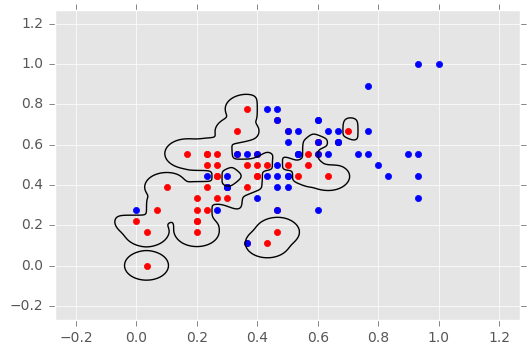

In [433]:
clf.visualize()

In [ ]:
clf.cross_validate()
clf.accuracy

In [378]:
np.exp(-50)

1.9287498479639178e-22

In [4]:
df = pd.read_csv('ex8a.txt', sep=' |:', header=None, engine='python')
df.columns = ['razred', 'c', 'a', 'd', 'b']
df.drop(['c', 'd'], 1, inplace=True)

In [5]:
df[:10]

,razred,a,b
0,1,0.107143,0.603070
1,1,0.093318,0.649854
2,1,0.097926,0.705409
3,1,0.155530,0.784357
4,1,0.210829,0.866228
5,1,0.328341,0.929094
6,1,0.429724,0.934942
7,1,0.620968,0.934942
8,1,0.756912,0.910088
9,1,0.819124,0.879386


In [7]:
clf = SVM(df, kernel='radial')

In [8]:
clf.fit(C=10)

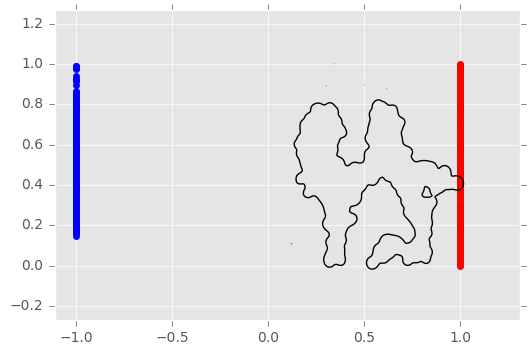

In [9]:
clf.visualize()